# Import

In [2]:
# python lib
import os
import sys
import matplotlib.pyplot as plt
import math
# other lib
from tensorflow.keras.losses import Loss
import tensorflow.keras.backend as K
import tensorflow as tf
import efficientnet.tfkeras as efn

util_path = "../utils"

# custom lib
sys.path.insert(0, os.path.join(util_path, "tfrecord/image"))
import tfrecord_utils
import tfrecord_preprocess

dataset_path = "./test_dataset/losses/image"

# Cross Entropy Loss

In [3]:
class CrossEntropyLoss(Loss):
    def __init__(self, **kwargs):
        super(CrossEntropyLoss, self).__init__(**kwargs)
        self.delta = 1e-7
    def __call__(self, y_pred, y_true):
        return -K.sum(K.cast_to_floatx(y_true) * K.log(K.l2_normalize(K.cast_to_floatx(y_pred)) + self.delta))

In [4]:
input_tensor_pred1 = tf.constant([0.1, 0.03, 0.05, 0.2, 0.9, 0.0, 0.1, 0.2, 0.12, 0.03])
input_tensor_pred2 = tf.constant([0.1, 0.03, 0.05, 0.2, 0.0, 0.1, 0.2, 0.12, 0.03, 0.9])
input_tensor_true = tf.constant([0, 0, 0, 0, 1, 0, 0, 0, 0, 0])
loss = CrossEntropyLoss()

print(loss(input_tensor_pred1, input_tensor_true))
print(loss(input_tensor_pred2, input_tensor_true))

tf.Tensor(0.06837557, shape=(), dtype=float32)
tf.Tensor(16.118095, shape=(), dtype=float32)


In [11]:
class RMSELoss(Loss):
    def __init__(self, **kwargs):
        super(RMSELoss, self).__init__(**kwargs)
    def __call__(self, y_pred, y_true):
        return K.mean(K.square(K.cast_to_floatx(y_true) - K.cast_to_floatx(y_pred)))

In [12]:
input_tensor_pred1 = tf.constant([0.1, 0.03, 0.05, 0.2, 0.9, 0.0, 0.1, 0.2, 0.12, 0.03])
input_tensor_pred2 = tf.constant([0.1, 0.03, 0.05, 0.2, 0.0, 0.1, 0.2, 0.12, 0.03, 0.9])
input_tensor_true = tf.constant([0, 0, 0, 0, 1, 0, 0, 0, 0, 0])
loss = RMSELoss()

print(loss(input_tensor_pred1, input_tensor_true))
print(loss(input_tensor_pred2, input_tensor_true))

tf.Tensor(0.012870002, shape=(), dtype=float32)
tf.Tensor(0.19286999, shape=(), dtype=float32)


# ArcFaceLoss

In [4]:
class ArcMarginProduct(tf.keras.layers.Layer):
    '''
    Implements large margin arc distance.

    Reference:
        https://arxiv.org/pdf/1801.07698.pdf
        https://github.com/lyakaap/Landmark2019-1st-and-3rd-Place-Solution/
            blob/master/src/modeling/metric_learning.py
    '''
    def __init__(self, n_classes, s=30, m=0.50, easy_margin=False, ls_eps=0.0, **kwargs):
        super(ArcMarginProduct, self).__init__(**kwargs)

        self.n_classes = n_classes
        self.s = s
        self.m = m
        self.ls_eps = ls_eps
        self.easy_margin = easy_margin
        self.cos_m = tf.math.cos(m)
        self.sin_m = tf.math.sin(m)
        self.th = tf.math.cos(math.pi - m)
        self.mm = tf.math.sin(math.pi - m) * m

        
    def build(self, input_shape):
        super(ArcMarginProduct, self).build(input_shape[0])

        self.W = self.add_weight(
            name='W',
            shape=(int(input_shape[0][-1]), self.n_classes),
            initializer='glorot_uniform',
            dtype='float32',
            trainable=True,
            regularizer=None)


    def call(self, inputs):
        X, y = inputs
        y = tf.cast(y, dtype=tf.int32)
        cosine = tf.matmul(tf.math.l2_normalize(X, axis=1), tf.math.l2_normalize(self.W, axis=0))
        sine = tf.math.sqrt(1.0 - tf.math.pow(cosine, 2))
        phi = cosine * self.cos_m - sine * self.sin_m
        
        if self.easy_margin:
            phi = tf.where(cosine > 0, phi, cosine)
        else:
            phi = tf.where(cosine > self.th, phi, cosine - self.mm)
            
        one_hot = tf.cast(tf.one_hot(y, depth=self.n_classes), dtype=cosine.dtype)
        
        if self.ls_eps > 0:
            one_hot = (1 - self.ls_eps) * one_hot + self.ls_eps / self.n_classes

        output = (one_hot * phi) + ((1.0 - one_hot) * cosine)
        output *= self.s
        
        return output

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


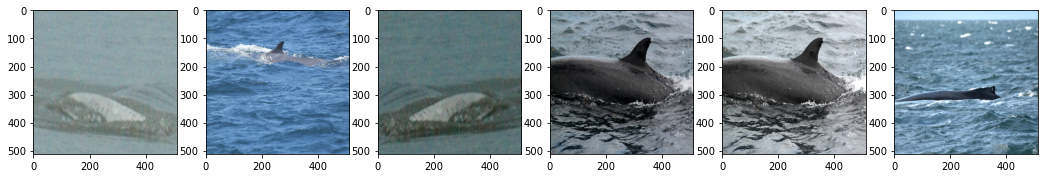

In [13]:
# to tfrecord
tfrecord_utils.image2tfrecord(dataset_path, dataset_path)

filenames = [os.path.join(dataset_path, filename) for filename in os.listdir(dataset_path) if "tfrecord" in filename]
dataset = tfrecord_preprocess.get_training_dataset(filenames)

fig = plt.figure(figsize=(18,8))
batch_imgs = []
batch_labels = []
for index, data in enumerate(dataset):
    for b_i, b in enumerate(range(tfrecord_preprocess.BATCH_SIZE)):
        ax = fig.add_subplot(1, 6, index * tfrecord_preprocess.BATCH_SIZE + b_i + 1)
        ax.imshow(data[0]["input/image"][b])
        batch_imgs.append(data[0]["input/image"])
        batch_labels.append(data[1])
    if index == 2:
        break
plt.show()


In [14]:
backbone = efn.EfficientNetB5(include_top=False, weights='noisy-student')
backbone.trainable=True
pooling = tf.keras.layers.GlobalAveragePooling2D(name='head/pooling')
dropout = tf.keras.layers.Dropout(0.3, name='head/dropout')
dense = tf.keras.layers.Dense(512, name='head/dense')
dense

In [19]:
x = backbone(batch_imgs[0])
x = pooling(x)
embeded = dropout(x)
margin = ArcMarginProduct(
        n_classes=2,
        s=30,
        m=0.3,
        name='head/arc_margin',
        dtype='float32'
)
margin_result = margin([embeded, batch_labels[0]])
margin_result

<tf.Tensor: id=54099, shape=(2, 2), dtype=float32, numpy=
array([[ 0.3381295 ,  0.06315032],
       [-0.86412066, -0.13401483]], dtype=float32)>

# Compare the Loss